In [1]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col


def reduce_mem_usage(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

The ideas and a lot of code was copied from other scripts. It's a mix!!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import datetime
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
sns.set()

import pickle
def save_to_disk(obj, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

%matplotlib inline

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


# Read Data and Merge

In [3]:
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv', index_col = 'TransactionID')
print('Successfully loaded train_identity')

train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv', index_col = 'TransactionID')
print('Successfully loaded train_transaction')

test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv', index_col = 'TransactionID')
print('Successfully loaded test_identity')

test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv', index_col = 'TransactionID')
print('Successfully loaded test_transaction')

sub = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')
print('Successfully loaded sample_submisssion')

print('Data was successfully loades!')

print('Merging data....')
train = train_transaction.merge(train_identity, how = 'left', left_index = True, right_index = True)
test = test_transaction.merge(test_identity, how = 'left', left_index = True, right_index = True)

print('Data was successfully merged!')

del train_identity, train_transaction, test_identity, test_transaction

print('Train dataset has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('Test dataset has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Successfully loaded train_identity
Successfully loaded train_transaction
Successfully loaded test_identity
Successfully loaded test_transaction
Successfully loaded sample_submisssion
Data was successfully loades!
Merging data....
Data was successfully merged!
Train dataset has 590540 rows and 433 columns
Test dataset has 506691 rows and 432 columns


We have a lot of features, let's start exploring our dataset.

# Model and Feature Engineering

In [4]:
train_copy = train.copy()
test_copy = test.copy()

In [5]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    
    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = 'Others'
    gc.collect()
    return dataframe

In [6]:
# split some features and replace values
train = id_split(train)
test = id_split(test)

In [7]:
drop_features = ['id_24', 'id_25', 'id_08', 'id_07', 'id_21', 'id_26', 'id_27', 'id_23', 'id_22', 'id_18', 'id_34',
                 'V141', 'V142', 'V146', 'V138', 'V151', 'V152', 'V333', 'V338', 'V339', 'V325', 'V332', 'V324',
                 'V330', 'V329', 'V322', 'V323', 'V278', 'V277', 'V252', 'V253', 'V254', 'V260', 'V263', 'V249',
                 'V266', 'V267', 'V268', 'V273', 'V276', 'V275', 'V247', 'V241', 'V240', 'V237', 'V235', 'V225',
                 'V224', 'V224', 'V248', 'V211', 'V213', 'V196', 'V205', 'V183', 'V206', 'V192', 'V191', 'V181',
                 'V193', 'V172', 'V173', 'V202', 'V203', 'V177', 'V179', 'V194', 'V185', 'V184', 'V175', 'V174', 
                 'V195', 'V197', 'V198', 'V208', 'V210', 'V227', 'V251', 'V250', 'V271', 'V270', 'V225', 'V89',
                 'V256', 'V3', 'V1', 'V2', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V46', 'V42', 'V43',
                 'V47', 'V41', 'V39', 'V36', 'V35', 'V51', 'V50', 'V49', 'V48', 'V88', 'V93', 'V85', 'V84', 'V83',
                 'V81', 'V90', 'V91', 'V92', 'V94', 'V80', 'V79', 'V75', 'V75', 'V68', 'V27', 'V28', 'V53', 'V74',
                 'V73', 'V72', 'V66', 'V54', 'V67', 'V64', 'V63', 'V62', 'V61', 'V71', 'V69', 'V55', 'V60', 'V59',
                 'V58', 'V57', 'V65', 'V56', 'V70', 'V22', 'V23', 'V24', 'V34', 'V33', 'V32', 'V31', 'V30', 'V29',
                 'V26', 'V25', 'V15', 'V21', 'V14', 'V16', 'V17', 'V18', 'V19', 'V12', 'V20', 'V13', 'V301', 'V300',
                 'V296', 'V289', 'V288', 'V114', 'V110', 'V105', 'V104', 'V103', 'V102', 'V101', 'V100', 'V95',
                 'V99', 'V98', 'V107', 'V111', 'V112', 'V106', 'V113', 'V108', 'V134', 'V133', 'V135', 'V132',
                 'V131', 'V130', 'V129', 'V126', 'V125', 'V124', 'V123', 'V122', 'V121', 'V120', 'V119', 'V118',
                 'V117', 'V116', 'V115', 'V109', 'V294', 'V305', 'V304', 'V303', 'V302', 'V299', 'V298', 'V297',
                 'V295', 'V293', 'V292', 'V291', 'V290', 'V287', 'V286', 'V285', 'V289', 'V279', 'V309', 'V316',
                 'V318', 'V319', 'C3', 'M1']

In [8]:
# filter usefull features with the e.d.a
usefull_features = [col for col in train.columns if col not in drop_features]
train = train[usefull_features]
usefull_features.remove('isFraud')
test = test[usefull_features]

In [9]:
# New feature - log of transaction amount. ()
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [10]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 
          'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 
          'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 
          'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 
          'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 
          'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 
          'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
          'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [11]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [12]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
#     df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
#     df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
#     df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
#     df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df
    
train=setTime(train)
test=setTime(test)

In [13]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    
    return data

In [14]:
train = addNewFeatures(train)
test = addNewFeatures(test)

In [15]:
i_cols = ['card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [16]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [17]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


# for col in ['DT_M','DT_W','DT_D']:
#     temp_df = pd.concat([train[[col]], test[[col]]])
#     fq_encode = temp_df[col].value_counts().to_dict()
            
#     train[col+'_total'] = train[col].map(fq_encode)
#     test[col+'_total']  = test[col].map(fq_encode)

# periods = ['DT_M','DT_W','DT_D']
# i_cols = ['uid']
# for period in periods:
#     for col in i_cols:
#         new_column = col + '_' + period
            
#         temp_df = pd.concat([train[[col,period]], test[[col,period]]])
#         temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
#         fq_encode = temp_df[new_column].value_counts().to_dict()
            
#         train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
#         test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
#         train[new_column] /= train[period+'_total']
#         test[new_column]  /= test[period+'_total']

In [18]:
TransactionDT1 = train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
dt_m = TransactionDT1.dt.date.astype('str').str[:7]

In [19]:
# drop noisy columns    
train.drop(['TransactionDT', 'uid','uid2','uid3', 'DT', 'DT_hour','DT_day_week',
            'id_30','id_31','id_33', 'D1', 'D2', 'D9'], axis = 1, inplace = True)
test.drop(['TransactionDT', 'uid','uid2','uid3', 'DT', 'DT_hour','DT_day_week', 'id_30','id_31','id_33', 'D1', 'D2', 'D9'], axis = 1, inplace = True)

In [20]:
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [21]:
def agg_features(df):
    columns_a = ['TransactionAmt', 'id_02', 'D15']
    columns_b = ['card1', 'card4', 'addr1']
    for col_a in columns_a:
        for col_b in columns_b:
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')
    return df

test = agg_features(test)
train = agg_features(train)

In [22]:
def feature_cents(df):
    return (np.modf(df['TransactionAmt'])[0] * 1000).round(5).astype(np.uint16)

train['Cents'] = feature_cents(train)
test['Cents'] = feature_cents(test)

In [23]:
def feature_ProductCD_W_cents(df):
    a = ((df['Cents'] == 0) | (df['Cents'] == 500) | (df['Cents'] == 950))
    b = df['ProductCD'] == 'W'
    return (a & b).astype(np.uint8)

train['Cents_ProductCD_W'] = feature_cents(train)
test['Cents_ProductCD_W'] = feature_cents(test)

In [24]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [25]:
print(list(train.columns))

['isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V37', 'V38', 'V40', 'V44', 'V45', 'V52', 'V76', 'V77', 'V78', 'V82', 'V86', 'V87', 'V96', 'V97', 'V127', 'V128', 'V136', 'V137', 'V139', 'V140', 'V143', 'V144', 'V145', 'V147', 'V148', 'V149', 'V150', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V176', 'V178', 'V180', 'V182', 'V186', 'V187', 'V188', 'V189', 'V190', 'V199', 'V200', 'V201', 'V204', 'V207', 'V209', 'V212', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234'

In [26]:
X = train.drop(['isFraud'], axis = 1)
y = train['isFraud']

print('Our train set have {} columns'.format(train.shape[1]))
print('Our test set have {} columns'.format(test.shape[1]))

gc.collect()

Our train set have 295 columns
Our test set have 294 columns


0

In [27]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.005,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':100000,
                    'max_bin':255,
                    'verbose':-1,
                    'random_state': 47,
                    'early_stopping_rounds':100, 
                }

In [28]:
%%time

columns = X.columns
y_preds = np.zeros(test.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

NFOLDS = len(np.unique(dt_m)) # 6

for fold_n, month in enumerate(np.unique(dt_m)):
    X_train, y_train = X[~dt_m.isin([month])][columns], y[~dt_m.isin([month])]
    X_valid, y_valid = X[dt_m.isin([month])][columns], y[dt_m.isin([month])]
    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    save_to_disk(y_pred_valid, 'y_pred_valid_fold{}.pkl'.format(fold_n))
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    
    y_pred_test = clf.predict(test)
    save_to_disk(y_pred_test, 'y_pred_test_fold{}.pkl'.format(fold_n))
    y_preds += y_pred_test / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")

(453219, 294) (453219,) (137321, 294) (137321,)
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.943468	valid_1's auc: 0.883683
[400]	training's auc: 0.965762	valid_1's auc: 0.895437
[600]	training's auc: 0.981638	valid_1's auc: 0.904041
[800]	training's auc: 0.989597	valid_1's auc: 0.909396
[1000]	training's auc: 0.993878	valid_1's auc: 0.913564
[1200]	training's auc: 0.996312	valid_1's auc: 0.916286
[1400]	training's auc: 0.997771	valid_1's auc: 0.918095
[1600]	training's auc: 0.998611	valid_1's auc: 0.919294
[1800]	training's auc: 0.999128	valid_1's auc: 0.920057
[2000]	training's auc: 0.999453	valid_1's auc: 0.920662
[2200]	training's auc: 0.999653	valid_1's auc: 0.921107
[2400]	training's auc: 0.999776	valid_1's auc: 0.921466
[2600]	training's auc: 0.999861	valid_1's auc: 0.921609
Early stopping, best iteration is:
[2615]	training's auc: 0.999865	valid_1's auc: 0.921639
Fold 1 | AUC: 0.921639236108881
(497955, 294) (497955,) (92585, 294) (9258

# Submission

In [29]:
submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')
submission['isFraud'] = y_preds
submission.head()

,TransactionID,isFraud
0,3663549,0.000525
1,3663550,0.002627
2,3663551,0.001490
3,3663552,0.001575
4,3663553,0.001855


In [30]:
submission.to_csv('submission.csv', index=False)

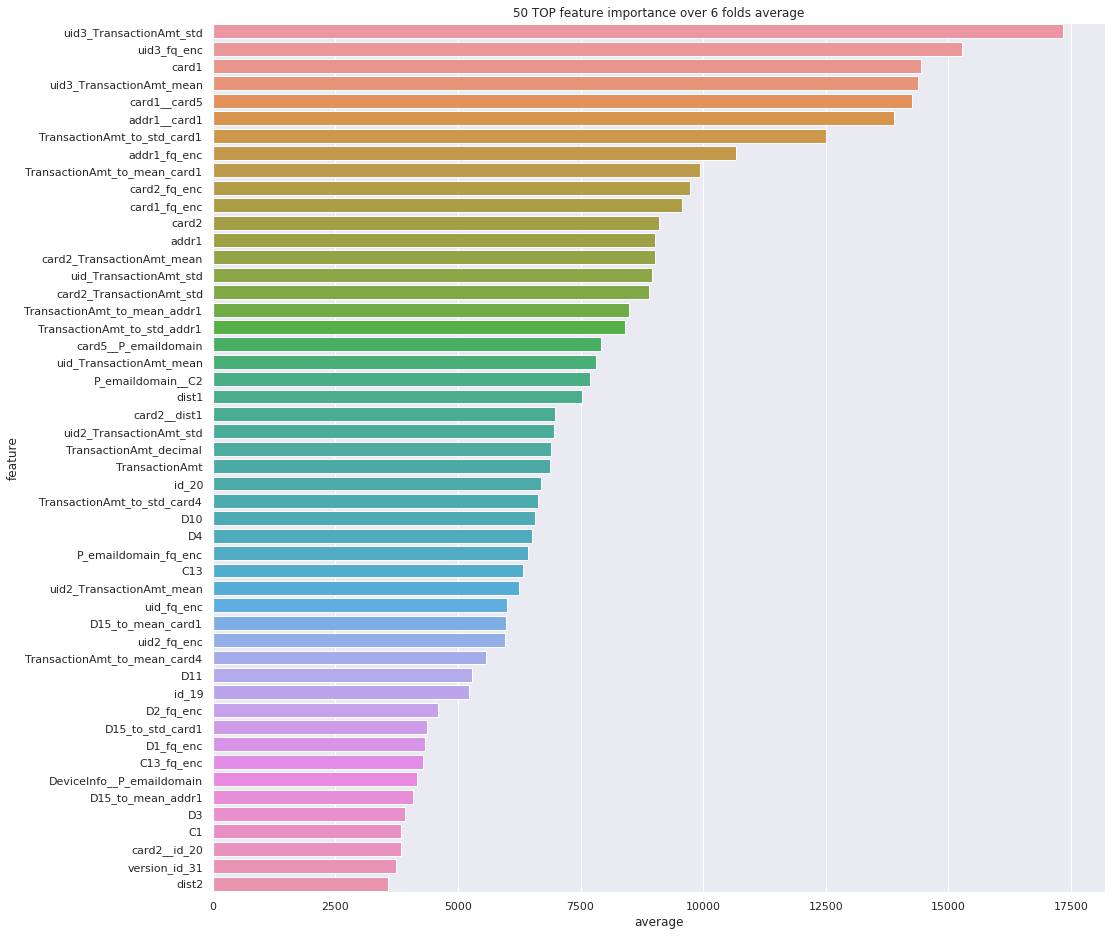

In [31]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(NFOLDS)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(NFOLDS));